# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [6]:
df = pd.read_csv('../data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [7]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [8]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [9]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [10]:
wrong_treatment = ((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')).sum()

In [11]:
wrong_control = ((df['group'] == 'control') & (df['landing_page'] != 'old_page')).sum()

In [12]:
wrong_treatment + wrong_control

3893

**f.** Do any of the rows have missing values?

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


<font color="red">No missing values.<font>

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [14]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
          ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]

In [15]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
wrong_treatment2 = ((df2['group'] == 'treatment') & (df2['landing_page'] != 'new_page')).sum()
wrong_control2 = ((df2['group'] == 'control') & (df2['landing_page'] != 'old_page')).sum()
wrong_treatment2 + wrong_control2

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [16]:
df2.shape

(290585, 5)

In [17]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [18]:
df2.user_id.value_counts().head()

773192    2
851104    1
688307    1
718297    1
838144    1
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [19]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [20]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
df2.drop_duplicates(subset='user_id', inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.value_counts().head()

/Users/seanhoyt/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


851104    1
688307    1
718297    1
838144    1
728209    1
Name: user_id, dtype: int64

In [21]:
df2.shape

(290584, 5)

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [22]:
df2.converted.mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
control_cr = df2[df['group'] == 'control'].converted.mean()
control_cr

/var/folders/hm/76vk5x9156vcx4df2s8mw2hm0000gn/T/ipykernel_13455/2805132061.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_cr = df2[df['group'] == 'control'].converted.mean()


0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
treatment_cr = df2[df['group'] == 'treatment'].converted.mean()
treatment_cr

/var/folders/hm/76vk5x9156vcx4df2s8mw2hm0000gn/T/ipykernel_13455/1278796718.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  treatment_cr = df2[df['group'] == 'treatment'].converted.mean()


0.11880806551510564

In [25]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_cr - control_cr
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [26]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

<font color='red'>Based on the conversion rates for the treatment and the control groups, there seemed to be a lower conversion rate for the treatment group than the control group, indicating that the new page may not lead to more purchases than the old page.</font>

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

The Null Hypothesis is that the new page leads to as many or less conversions than the old page. The Alternative Hypothesis is that the new page leads to more conversions than the old page.

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

<font color='red'>Because our Null hypothesis assumes that $p_{new} = p_{old}$, the conversion rate for the new and old pages should be equal to the entire conversion rate in the data, therefore being the same.</font>

In [27]:
conv_rate_new = df2.converted.mean()
conv_rate_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [28]:
conv_rate_old = df2.converted.mean()
conv_rate_old

0.11959708724499628

In [29]:
conv_rate_new - conv_rate_old

0.0

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [30]:
treatment_rows = df2[df2['group'] == 'treatment'].shape[0]
treatment_rows

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [31]:
control_rows = df2[df2['group'] == 'control'].shape[0]
control_rows

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [32]:
# Simulate a Sample for the treatment Group
# 0 or 1 outcome for the number of people who got the treatment
treatment_sample = np.random.choice([0, 1], size=treatment_rows, p=[1-conv_rate_new, conv_rate_new])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [33]:
# Simulate a Sample for the control Group
control_sample = np.random.choice([0, 1], size=control_rows, p=[1-conv_rate_old, conv_rate_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [34]:
treatment_sample.mean() - control_sample.mean()

-0.0011722121999147295


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [35]:
# sampling distribution
# use the binomal function (because we are sampling 1s or 0s) to take advantage of 
# the function speed over looping/sampling

# returns the number number of treatment rows that converted (based on the conversion rate and binomical dist) for
# 10,000 samples and divides by the number of treatment rows to get the pct conversion for the samples
treatment_sample = np.random.binomial(treatment_rows, conv_rate_new, 10000) / treatment_rows
control_sample = np.random.binomial(control_rows, conv_rate_old, 10000) / control_rows
p_diffs = treatment_sample - control_sample

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

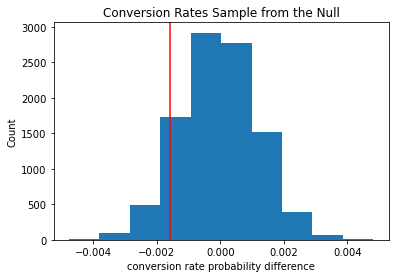

In [36]:
plt.hist(p_diffs);
plt.xlabel("conversion rate probability difference")
plt.ylabel("Count")
plt.title("Conversion Rates Sample from the Null")
plt.axvline(obs_diff, color='red')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [37]:
(p_diffs > obs_diff).mean()

0.8992

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

<font color='red'>The p-value calculated above of 0.902, considering a Type I error rate of (0.05) clearly shows that we cannot reject the null hypothesis that the old page has a conversion equal to or greater than the new page. By bootstrap sampling from a Null that the two pages had equal conversion rates, we can see from the historgram above and the p-value that the observed conversion rate is much less than large majority of the null distribution. Because the p-value and its extreme toward the alternative hypothesis (greater than the null), contain most of the null distribution, we do not have evidence to reject the null hypothesis.</font>



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [38]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[df2['landing_page'] == "old_page"].converted.sum()

# number of conversions with the new_page
convert_new = df2[df2['landing_page'] == "new_page"].converted.sum()

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == "old_page"].shape[0]

# number of individuals who received new_page
n_new = df2[df2['landing_page'] == "new_page"].shape[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [39]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(
    [convert_new, convert_old],
    [n_new, n_old],
    alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


<font color='red'>The p-value is very close to (and effectively the same as) the p-value calculated previously. Therefore, this p-value does indicate the same result that the null hypothesis cannot be rejected.<font>

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color="red">Because it is binary (2 choices), logistic regression should be used.<font>

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [40]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']]=pd.get_dummies(df['landing_page'])
df2.drop('old_page', axis=1, inplace=True)

/var/folders/hm/76vk5x9156vcx4df2s8mw2hm0000gn/T/ipykernel_13455/2238491058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
/Users/seanhoyt/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/seanhoyt/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [41]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-05-11 18:42 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

<font color='red'>The null hypothsis in the regression model is that the coefficient has a value of 0. This says that there is no relationship between the pages and converting. This is slightly different from the null hypothesis from the A/B test because it implies a two-sided test as opposed to a one-sided test in the hypothesis test from Part II.</font>

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<font color='red'>Other factors you could look at are how the time of day or location affect whether a user converts. The other question to ask is whether the test ran for a long enough time so that returning customers could adjust to the new page layout. One disadvantage that could result from adding more explantory variables to a linear model is multicolinearity. If two of the explanatory variables are also correlated, this can cause strange values in the coefficients to show up, leading to incorrect interpretations.</font>

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [43]:
# Read the countries.csv
countries = pd.read_csv('../data/countries.csv')

In [44]:
# Join with the df2 dataframe
df2= df2.set_index('user_id').join(countries.set_index('user_id'), how='inner', on='user_id', lsuffix='df2', rsuffix='countries')

In [45]:
# Create the necessary dummy variables
df2['intercept'] = 1
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

In [46]:
# Fit your model, and summarize the results
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK', 'CA']])
result = logit_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-05-11 18:42 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
==================================================================

"""

In [47]:
1/np.exp(-.0149)

1.0150115583846535

In [48]:
np.exp(.0099)

1.0099491671175422

In [49]:
1/np.exp(-0.408)

1.5038071611701118

<font color='red'>Based on the logistic regression results above, we cannot reject the null hypothesis for any of the explanatory variables. Based on the results, the old page more 1.015 times effective at converting users, users in Canada are 1.01 times less likely to convert to the convert compared to US customers and UK customers are 1.5 times more likely to convert compared to US customers. However, the p-values are too large to convince us that there is a statistically significat correlation in effect here. The differences are small and since we did not have evidence to reject the null hypothesis, it would be best to stay with the old page.</font>

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [50]:
df2['UK_abpage'] = df2['UK'] * df2['ab_page']
df2['CA_abpage'] = df2['CA'] * df2['ab_page']

In [51]:
# Fit your model, and summarize the results
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK', 'CA', 'UK_abpage', 'CA_abpage']])
result = logit_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-05-11 18:42 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_abpage     0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_abpage    -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

In [52]:
1/np.exp(-.0206)

1.020813644503746

In [53]:
1/np.exp(-.0057)

1.0057162759095335

In [54]:
1/np.exp(-0.175)

1.191246216612358

<font color='red'>Using the interactions, the old page shows a 1.02 times higher conversion than the new page. However, both the UK and CA now show less conversion than the US (UK 1.005 times less, CA 1.19 times less). For the UK/Page interaction, there is a positive correlation with conversion and a negative correlation for the CA/Page interaction, however, because these are higher order terms, they are more difficult to use for inference compared to the others where we can clearly see the effect it is having on the conversion. However as with the case above, the p-values are too large to be convinced of any statistical significance in the correlation.</font>

## Conclusion

<font color="red">In this analysis, multiple techniques were utilized to determine whether a new landing page should be used in lieu of the old page. The results of the hypothesis test showed a p-value of 0.9, indicating that we cannot reject the null hypothesis that the old page leads to just as many, if not more conversions than the new page. Using the data to build a logistic regression model also showed high p-values, hinting that the correlations found in the model are not statistically significant. The recommendation resulting from this analysis to to continue use of the old page rather than converting to the new page.</font>